# Importing Dataset and Libraries

In [ ]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the NIST handwritten digit dataset
digits = load_digits()

# Convert the dataset to a DataFrame for easier manipulation
data = pd.DataFrame(data=digits.data, columns=[f'pixel_{i}' for i in range(digits.data.shape[1])])
data['target'] = digits.target

# Dimension Reductionality Techniques

# TSNE

Nonlinear, not suitable for SVM classifier

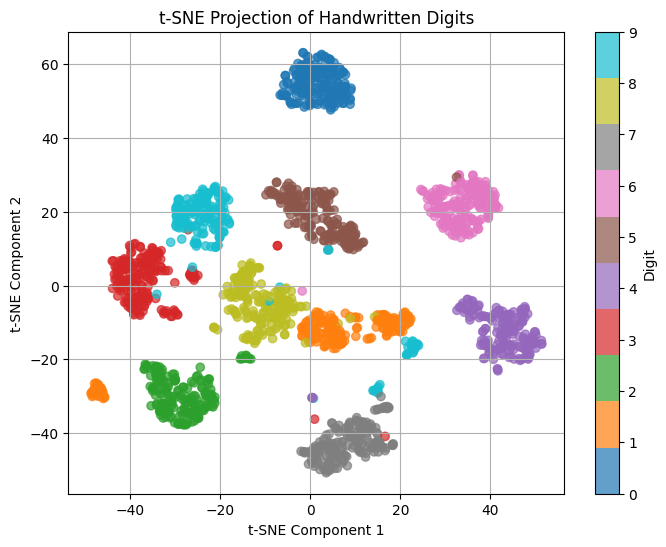

In [ ]:
from sklearn.manifold import TSNE

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# PCA & UMAP

Explain PCA & UMAP here

In [ ]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply UMAP to reduce to 30D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

c:\Users\qoste\AppData\Local\Programs\Python\Python38\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### PCA and UMAP Projections

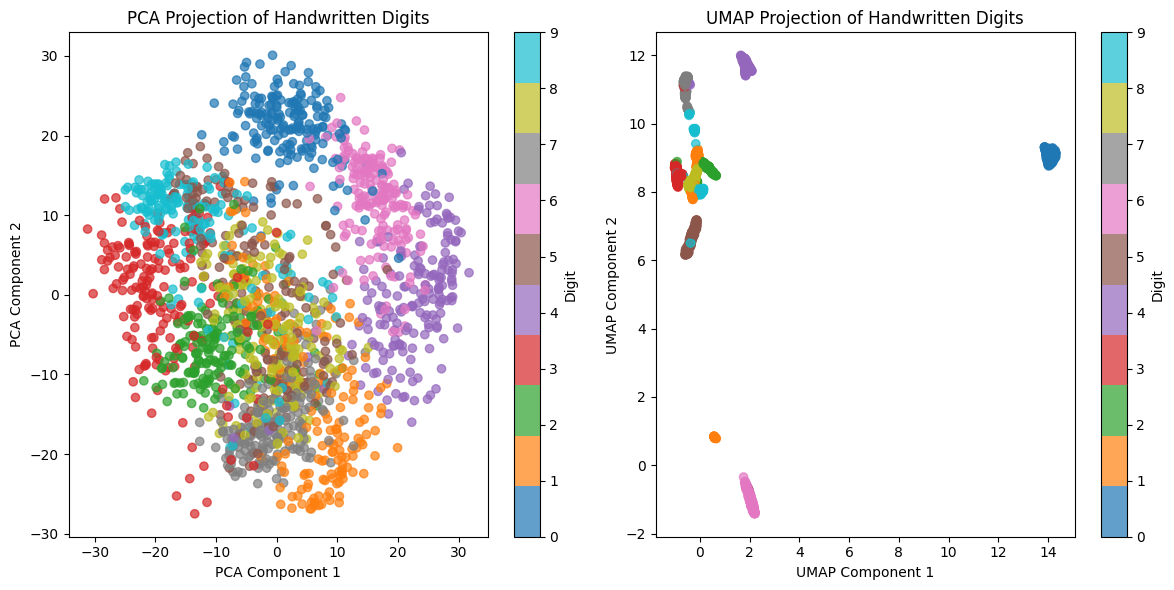

In [68]:
import matplotlib.pyplot as plt

# Step 3: Plot PCA Projection
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Creates a subplot (1 row, 2 columns, first plot)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Handwritten Digits')
plt.colorbar(label='Digit')

# Step 4: Plot UMAP Projection
plt.subplot(1, 2, 2)  # Second plot in the subplot grid
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection of Handwritten Digits')
plt.colorbar(label='Digit')

# Step 5: Display the plots
plt.tight_layout()

plt.show()

### Setup Model

In [55]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


### Hyperparameter Tuning (C)

In [56]:
c_values = range(1, 10)

# Use this to store our results
scores = np.ones((len(c_values), 5))

for (i, c_candidate) in enumerate(c_values):
    print("Cross validating for %d..." % c_candidate)

    # Initializing our model with the given C value
    model = LinearSVC(C=c_candidate, random_state=42, max_iter=10000, dual='auto')
    current_scores = cross_val_score(model, X_train, y_train, cv=5)
    scores[i] = current_scores

Cross validating for 1...
Cross validating for 2...
Cross validating for 3...
Cross validating for 4...
Cross validating for 5...
Cross validating for 6...
Cross validating for 7...
Cross validating for 8...
Cross validating for 9...


### Figure 3

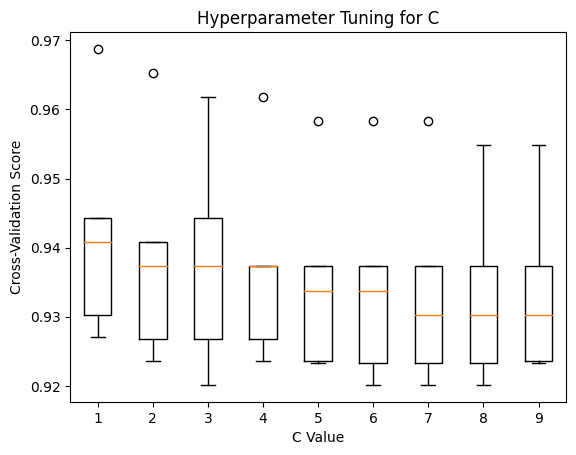

In [39]:
plt.boxplot(scores.T)
plt.title('Hyperparameter Tuning for C')
plt.xlabel('C Value')
plt.ylabel('Cross-Validation Score')
plt.show()

### Testing Model With Optimal C Value

In [43]:
# Setting up our model with the optimal C value (e.g., 1)
model = LinearSVC(C=1, dual='auto')

# Compute both training and test scores
cv_results = cross_validate(model, X_train, y_train, cv=5, return_train_score=True)

# Access training and test scores
train_scores = cv_results['train_score']
test_scores = cv_results['test_score']

# Display scores
print("Train Score (median): ", np.median(train_scores))
print("Test Score (median): ", np.median(test_scores))

Train Score (median):  0.9982593559617058
Test Score (median):  0.9407665505226481


### IGNORE: was looking into PCA, couldn't get it working :(

In [41]:
from sklearn.decomposition import PCA

# Step 1: Initialize PCA to reduce to 2 components
pca = PCA(n_components=2)

# Step 2: Fit PCA on the training data and transform it
X_train_pca = pca.fit_transform(X_train)

# Step 3: Transform the test data as well (if needed)
X_test_pca = pca.transform(X_test)

def plotSVMResults(X,y, model):

    # Step 1: Create a mesh grid for plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    # Step 2: Predict the class labels for the grid points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    features = set(y)

    Z_num = Z.copy()
    y_num = y.copy()

    ## Change nominal values to 0 or 1
    for (i,label) in enumerate(features):
        Z_num[Z_num[:,:]==label] = i 
        y_num[y_num[:]==label] = i 

    Z_num = Z_num.astype(int)
    y_num = y_num.astype(int)

    fig, ax = plt.subplots()

    #  Plot the decision boundary and the data points
    ax.contourf(xx, yy, Z_num, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y_num, edgecolors='k', marker='o')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('SVM Decision Boundary with LinearSVC')

    return (ax,fig)

In [42]:
plotSVMResults(X_train_pca, y_train, model)

NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.